# PyTango Device Server Tutorial: AutoScript Microscope Digital Twin

This tutorial demonstrates how to interact with a PyTango device server that simulates a microscope. The device server (`Device_AS_twin.py`).



## What You'll Learn
0. **Discovering what a device offers** (introspection)
1. Connecting to a PyTango device
2. Checking device state and status
3. Configuring detector parameters via attributes
4. Acquiring images from detectors
5. Understanding validation and error handling
6. Working with multiple detectors

## Prerequisites
Make sure the device server is running:
```bash
python Device_AS_twin.py test -nodb -dlist test/as/twin --port 10000
```

## Setup and Imports

In [1]:
import tango
import numpy as np
import matplotlib.pyplot as plt

# Configure matplotlib for better display
plt.rcParams['figure.figsize'] = (10, 8)
%matplotlib inline

## 1. Connecting to the Device

First, we need to connect to the PyTango device server. Since we're running in no-database mode, we use a special connection string.

In [2]:
# Connect to the device (no-database mode)
device_name = "tango://localhost:10000/test/as/twin#dbase=no"

try:
    device = tango.DeviceProxy(device_name)
    print(f"✓ Connected to device: {device.name()}")
except Exception as e:
    print(f"✗ Failed to connect: {e}")
    print("\nMake sure the device server is running:")
    print("  python Device_AS_twin.py test -nodb -dlist test/as/twin --port 10000")

✓ Connected to device: test/as/twin


## 2. Discovering Device Capabilities (Introspection)

**Important**: As a user, you typically don't have access to the server source code. PyTango provides powerful introspection capabilities to discover what a device offers.

Let's explore what this device can do!

### 2.1 List All Available Attributes

Attributes are properties you can read or write (like detector settings).

In [3]:
# Get all attributes
attributes = device.get_attribute_list()
print(f"Found {len(attributes)} attributes:\n")
for attr in sorted(attributes):
    print(f"  - {attr}")

Found 12 attributes:

  - State
  - Status
  - detector_A_active
  - detector_A_dwell_time
  - detector_A_resolution
  - detector_B_active
  - detector_B_dwell_time
  - detector_B_resolution
  - detector_C_active
  - detector_C_dwell_time
  - detector_C_resolution
  - microscope_connected


### 2.2 Get Detailed Information About Attributes

Let's examine specific attributes to understand their properties (type, read/write access, units, etc.).

In [4]:
# Examine a specific attribute in detail
attr_name = "detector_A_dwell_time"
attr_config = device.get_attribute_config(attr_name)

print(f"Attribute: {attr_name}")
print(f"  Data type: {attr_config.data_type}")
print(f"  Writable: {attr_config.writable}")
print(f"  Unit: {attr_config.unit}")
print(f"  Description: {attr_config.description}")

Attribute: detector_A_dwell_time
  Data type: 5
  Writable: READ_WRITE
  Unit: s
  Description: No description


### 2.3 Discover Attribute Patterns

Notice the naming pattern? Let's group attributes by detector to understand the structure better.

In [5]:
# Group attributes by detector
from collections import defaultdict

detector_attrs = defaultdict(list)
other_attrs = []

for attr in attributes:
    if attr.startswith('detector_'):
        # Extract detector name (e.g., 'detector_A' from 'detector_A_active')
        parts = attr.split('_')
        if len(parts) >= 2:
            detector = f"{parts[0]}_{parts[1]}"  # detector_A, detector_B, etc.
            property_name = '_'.join(parts[2:])   # active, dwell_time, resolution
            detector_attrs[detector].append(property_name)
    else:
        other_attrs.append(attr)

print("Detector Attributes (grouped):")
for detector, props in sorted(detector_attrs.items()):
    print(f"\n  {detector}:")
    for prop in sorted(props):
        print(f"    - {prop}")

print("\nOther Attributes:")
for attr in sorted(other_attrs):
    print(f"  - {attr}")

Detector Attributes (grouped):

  detector_A:
    - active
    - dwell_time
    - resolution

  detector_B:
    - active
    - dwell_time
    - resolution

  detector_C:
    - active
    - dwell_time
    - resolution

Other Attributes:
  - State
  - Status
  - microscope_connected


### 2.4 List All Available Commands

Commands are actions you can execute (like acquiring an image or connecting to the microscope).

In [6]:
# Get all commands
commands = device.get_command_list()
print(f"Found {len(commands)} commands:\n")
for cmd in sorted(commands):
    print(f"  - {cmd}")

Found 6 commands:

  - Connect
  - GetImage
  - GetStage
  - Init
  - State
  - Status


### 2.5 Get Detailed Command Information

Let's examine what inputs and outputs each command expects.

In [7]:
# Examine commands in detail (skip standard Tango commands)
standard_commands = {'State', 'Status', 'Init'}
custom_commands = [cmd for cmd in commands if cmd not in standard_commands]

print("Custom Commands (with input/output info):\n")
for cmd in sorted(custom_commands):
    config = device.get_command_config(cmd)
    print(f"  {cmd}:")
    print(f"    Input type: {config.in_type}")
    if hasattr(config, 'in_type_desc') and config.in_type_desc:
        print(f"    Input description: {config.in_type_desc}")
    print(f"    Output type: {config.out_type}")
    if hasattr(config, 'out_type_desc') and config.out_type_desc:
        print(f"    Output description: {config.out_type_desc}")
    print()

Custom Commands (with input/output info):

  Connect:
    Input type: DevString
    Input description: connection_string (None): Format "host:port" (e.g., "localhost:9001")
    Output type: DevString
    Output description: returns (None): Connection status message

  GetImage:
    Input type: DevString
    Input description: detector_name (None): Name of detector ('detector_A', 'detector_B', or 'detector_C')
    Output type: DevVarDoubleArray
    Output description: returns (None): Flattened 1D array of image data (reshape on client side using resolution)

  GetStage:
    Input type: DevVoid
    Input description: No input parameter (DevVoid)
    Output type: DevVarDoubleArray
    Output description: returns (None): List of 5 floats: [x, y, z, tilt, rotation]



### 2.6 Read Current Attribute Values

Now that we know what attributes exist, let's read their current values.

In [ ]:
# Read current values of detector_A attributes
print("Current detector_A configuration:")
print(f"  active: {device.detector_A_active}")
print(f"  dwell_time: {device.detector_A_dwell_time}s")
print(f"  resolution: {device.detector_A_resolution}")

print("\nMicroscope status:")
print(f"  connected: {device.microscope_connected}")

Current detector_A configuration:
  active: False
  dwell_time: 0.1s
  resolution: 256

Microscope status:
  connected: False


### 2.7 Summary: What We Discovered

From introspection alone, we learned:

1. **Three detectors** (A, B, C) each with:
   - `active` (boolean) - enable/disable detector
   - `dwell_time` (float, seconds) - pixel acquisition time
   - `resolution` (int) - image size

2. **Commands available**:
   - `Connect(host:port)` - connect to microscope
   - `GetImage(detector_name)` - acquire image from detector
   - `GetStage()` - get stage position

3. **Other attributes**:
   - `microscope_connected` - connection status

**This is powerful!** You can explore any PyTango device this way without reading the source code.

## 3. Checking Device State and Status

PyTango devices have states that indicate their current condition:
- **INIT**: Device initialized but not connected
- **STANDBY**: Connected and ready
- **RUNNING**: Acquiring data
- **FAULT**: Error condition

In [9]:
# Check initial state
state = device.state()
status = device.status()

print(f"Device State: {state}")
print(f"Device Status: {status}")

Device State: INIT
Device Status: Device initialized. Use Connect command to connect to microscope.


## 4. Connecting to the Microscope

Before we can acquire images, we need to connect to the microscope (or in this case, the digital twin simulator).

In [10]:
# Check if microscope is connected
print(f"Microscope connected: {device.microscope_connected}")

# Connect to microscope
result = device.Connect("localhost:9001")
print(f"\nConnection result: {result}")

# Verify connection
print(f"\nMicroscope connected: {device.microscope_connected}")
print(f"Device state: {device.state()}")

Microscope connected: False

Connection result: Connected to Digital Twin microscope at localhost:9001

Microscope connected: True
Device state: STANDBY


## 5. Understanding Detector Attributes

The device has three detectors (A, B, C), each with three configurable attributes:
- **active**: Whether the detector is enabled (must be True before configuration)
- **dwell_time**: Time spent per pixel in seconds
- **resolution**: Image size (width/height in pixels)

Let's explore detector_A's attributes:

In [11]:
# Check detector_A attributes
print("Detector A Configuration:")
print(f"  Active: {device.detector_A_active}")
print(f"  Dwell Time: {device.detector_A_dwell_time}s")
print(f"  Resolution: {device.detector_A_resolution}")

Detector A Configuration:
  Active: False
  Dwell Time: 0.1s
  Resolution: 256


## 6. Validation: Inactive Detector Protection

The device enforces that detectors must be activated before they can be configured or used. Let's see what happens if we try to acquire an image from an inactive detector:

In [12]:
# Try to get image from inactive detector (should fail)
try:
    image = device.GetImage("detector_A")
    print("✗ This should have failed!")
except Exception as e:
    print(f"✓ Correctly rejected: {e}")

✓ Correctly rejected: DevFailed[
    DevError[
        desc = Exception: Detector detector_A is not active. Set detector_A_active = True first.
        origin = Traceback (most recent call last):
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/.venv/lib/python3.11/site-packages/tango/server.py", line 1790, in wrapped_command_method
                return get_worker().execute(cmd_method, *args, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/.venv/lib/python3.11/site-packages/tango/green.py", line 110, in execute
                return fn(*args, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/Device_AS_twin.py", line 276, in GetImage
                raise Exception(f"Detector {detector_name} is not active. Set {detector_name}_active = True first.")
    

In [13]:
# Try to set dwell_time on inactive detector (should fail)
try:
    device.detector_A_dwell_time = 0.05
    print("✗ This should have failed!")
except Exception as e:
    print(f"✓ Correctly rejected: {e}")

✓ Correctly rejected: DevFailed[
    DevError[
        desc = Exception: Cannot set dwell_time: detector_A is not active. Set detector_A_active = True first.
        origin = Traceback (most recent call last):
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/.venv/lib/python3.11/site-packages/tango/server.py", line 177, in write_attr
                return get_worker().execute(write_method, self, value)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/.venv/lib/python3.11/site-packages/tango/green.py", line 110, in execute
                return fn(*args, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/Device_AS_twin.py", line 110, in write_detector_A_dwell_time
                raise Exception("Cannot set dwell_time: detector_A is not active. Set detector_A_active =

## 7. Configuring and Using a Detector

Now let's properly configure detector_A and acquire an image. The workflow is:
1. Activate the detector
2. Set dwell time
3. Set resolution
4. Acquire image

In [14]:
# Step 1: Activate detector
device.detector_A_active = True
print(f"✓ Activated detector_A")

# Step 2: Set dwell time
device.detector_A_dwell_time = 0.01
print(f"✓ Set dwell_time = 0.01s")

# Step 3: Set resolution
device.detector_A_resolution = 64
print(f"✓ Set resolution = 64")

# Verify configuration
print(f"\nFinal configuration:")
print(f"  Active: {device.detector_A_active}")
print(f"  Dwell Time: {device.detector_A_dwell_time}s")
print(f"  Resolution: {device.detector_A_resolution}")

✓ Activated detector_A
✓ Set dwell_time = 0.01s
✓ Set resolution = 64

Final configuration:
  Active: True
  Dwell Time: 0.01s
  Resolution: 64


## 8. Acquiring an Image

Now we can acquire an image! The device returns a flattened 1D array, which we need to reshape based on the resolution.

In [15]:
device.set_timeout_millis(15000)  # 15s------> why this?? - 5 second timeout in device side

In [16]:
# Check state before acquisition
print(f"State before acquisition: {device.state()}")

# Get the image (this will take ~5 seconds as it simulates acquisition)
print("\nAcquiring image...")
flattened_image = device.GetImage("detector_A")

# Reshape to 2D
resolution = device.detector_A_resolution
image = flattened_image.reshape(resolution, resolution)

# Check state after acquisition
print(f"\nState after acquisition: {device.state()}")

# Display image information
print(f"\nImage Information:")
print(f"  Shape: {image.shape}")
print(f"  Data type: {image.dtype}")
print(f"  Min/Max values: {image.min():.2f} / {image.max():.2f}")

State before acquisition: STANDBY

Acquiring image...

State after acquisition: STANDBY

Image Information:
  Shape: (64, 64)
  Data type: float64
  Min/Max values: 0.03 / 254.96


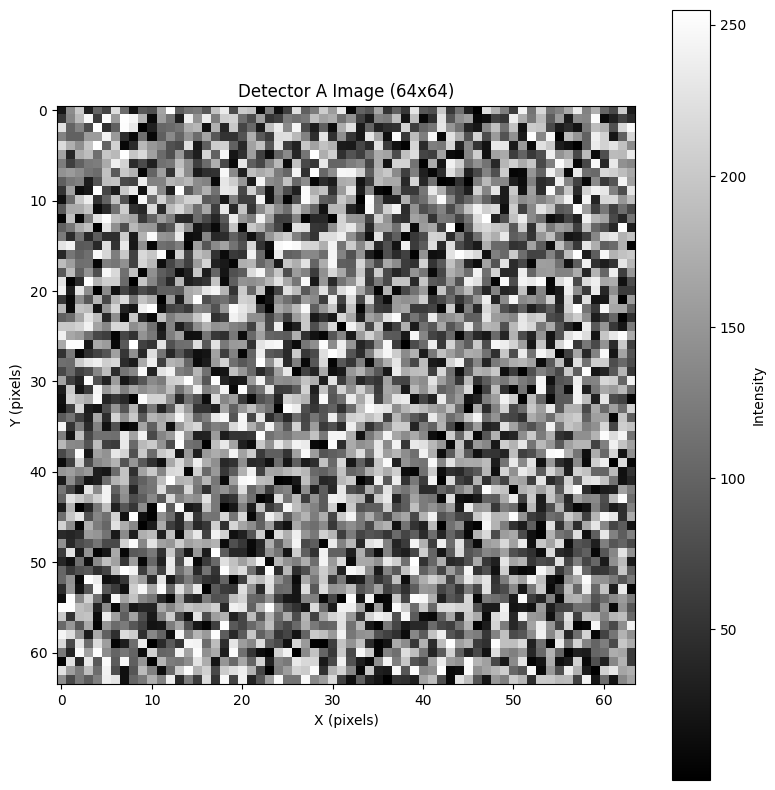

In [17]:
# Visualize the image
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')
plt.colorbar(label='Intensity')
plt.title(f'Detector A Image ({resolution}x{resolution})')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.tight_layout()
plt.show()

## 9. Acquisition Time Validation

The device prevents acquisitions that would take longer than 10 minutes (600 seconds). Let's try to configure an acquisition that's too long:

In [18]:
# Configure detector_B for a very long acquisition
device.detector_B_active = True
device.detector_B_resolution = 1000
device.detector_B_dwell_time = 1.0

# Calculate expected acquisition time
total_pixels = 1000 * 1000
expected_time = total_pixels * 1.0
print(f"Expected acquisition time: {expected_time:,} seconds ({expected_time/60:.1f} minutes)")

# Try to acquire (should fail)
try:
    image = device.GetImage("detector_B")
    print("✗ This should have failed!")
except Exception as e:
    print(f"\n✓ Correctly rejected long acquisition: {e}")

Expected acquisition time: 1,000,000.0 seconds (16666.7 minutes)

✓ Correctly rejected long acquisition: DevFailed[
    DevError[
        desc = Exception: Acquisition too long: 1000000.0s (max 600s). Reduce dwell_time or resolution.
        origin = Traceback (most recent call last):
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/.venv/lib/python3.11/site-packages/tango/server.py", line 1790, in wrapped_command_method
                return get_worker().execute(cmd_method, *args, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/.venv/lib/python3.11/site-packages/tango/green.py", line 110, in execute
                return fn(*args, **kwargs)
                       ^^^^^^^^^^^^^^^^^^^
              File "/Users/utkarshpratiush/project/just-learning/PyTango-tutorial/Device_AS_twin.py", line 281, in GetImage
                raise Exception

## 10. Working with Multiple Detectors

Let's configure and acquire images from multiple detectors with different settings:

In [19]:
# Configure detector_C
device.detector_C_active = True
device.detector_C_dwell_time = 0.02
device.detector_C_resolution = 128

print("Detector C Configuration:")
print(f"  Active: {device.detector_C_active}")
print(f"  Dwell Time: {device.detector_C_dwell_time}s")
print(f"  Resolution: {device.detector_C_resolution}")

# Acquire image
print("\nAcquiring image from detector_C...")
flattened_image_c = device.GetImage("detector_C")
image_c = flattened_image_c.reshape(128, 128)

print(f"✓ Acquired {image_c.shape} image from detector_C")

Detector C Configuration:
  Active: True
  Dwell Time: 0.02s
  Resolution: 128

Acquiring image from detector_C...
✓ Acquired (128, 128) image from detector_C


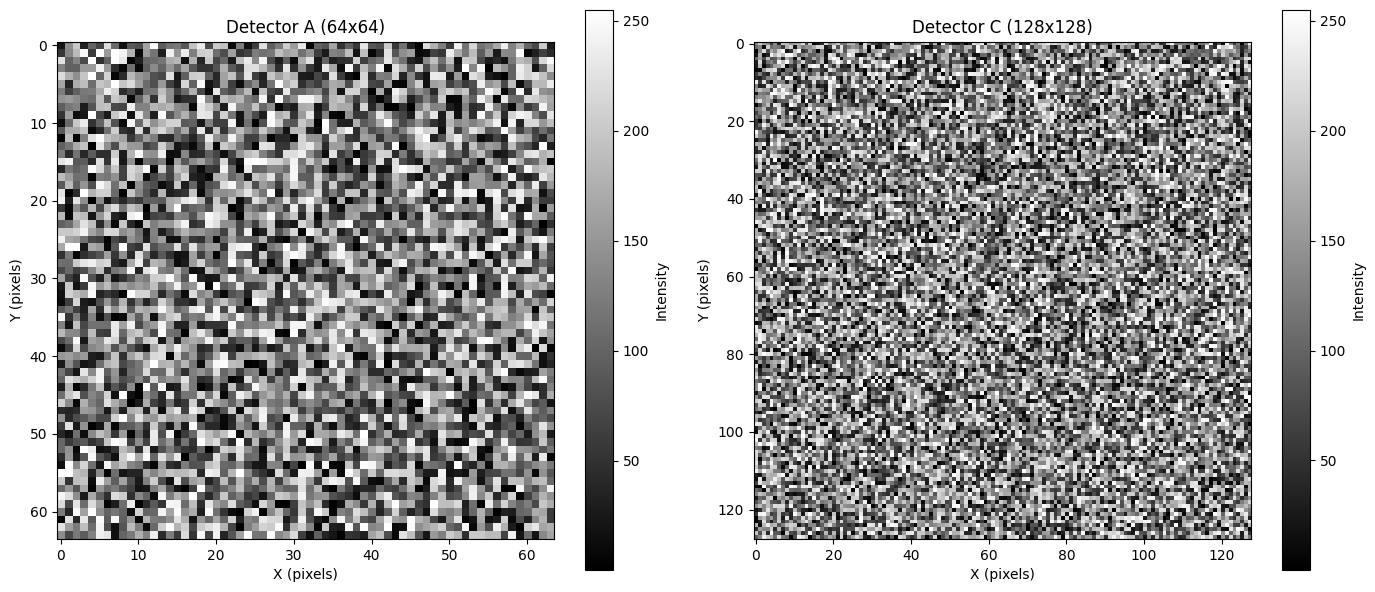

In [20]:
# Compare images from detector_A and detector_C
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Detector A
im1 = axes[0].imshow(image, cmap='gray')
axes[0].set_title(f'Detector A ({image.shape[0]}x{image.shape[1]})')
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')
plt.colorbar(im1, ax=axes[0], label='Intensity')

# Detector C
im2 = axes[1].imshow(image_c, cmap='gray')
axes[1].set_title(f'Detector C ({image_c.shape[0]}x{image_c.shape[1]})')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Y (pixels)')
plt.colorbar(im2, ax=axes[1], label='Intensity')

plt.tight_layout()
plt.show()

## 11. Getting Stage Position

The device can also report the microscope stage position (x, y, z, tilt, rotation):

In [21]:
# Get stage position
positions = device.GetStage()

print("Stage Position:")
labels = ['X', 'Y', 'Z', 'Tilt', 'Rotation']
for label, pos in zip(labels, positions):
    print(f"  {label}: {pos:.3f}")

Stage Position:
  X: 0.214
  Y: -9.745
  Z: 1.865
  Tilt: -0.809
  Rotation: 7.403


## 12. Summary and Best Practices

### Key Takeaways:

1. **Device Introspection**: Always start by exploring what a device offers
   ```python
   device.get_attribute_list()
   device.get_command_list()
   device.get_attribute_config(attr_name)
   device.get_command_config(cmd_name)
   ```

2. **Design Principle**: Always activate detector first, then configure parameters, then acquire
   ```python
   device.detector_A_active = True
   device.detector_A_dwell_time = 0.01
   device.detector_A_resolution = 64
   image = device.GetImage("detector_A")
   ```

3. **State Management**: Monitor device state to understand what's happening
   - INIT → STANDBY (after Connect)
   - STANDBY → RUNNING (during acquisition)
   - RUNNING → STANDBY (after acquisition completes)

4. **Validation**: The device protects against:
   - Using inactive detectors
   - Acquisitions that are too long (>10 minutes)
   - Operating without microscope connection

5. **Data Handling**: Images are returned as flattened 1D arrays
   - Always reshape using the resolution attribute
   - `image = flattened.reshape(resolution, resolution)`

6. **Multiple Detectors**: Each detector is independently configurable
   - Different resolutions and dwell times
   - Can be activated/deactivated independently

## 13. How to Write Your Own PyTango Device

Now that you've learned how to USE a PyTango device, let's see how EASY it is to write one!

The `Device_AS_twin.py` server uses clean, simple patterns that you can copy for your own devices.

### 13.1 Basic Structure

A PyTango device has three main parts:
1. **Attribute declarations** (at class level)
2. **Read/write methods** (for each attribute)
3. **Commands** (decorated with @command)

### 13.2 Declaring Attributes

Here's how attributes are declared in `Device_AS_twin.py`:

```python
from tango import AttrWriteType
from tango.server import Device, attribute, command

class DeviceASTwin(Device):
    # Declare attributes at class level
    detector_A_active = attribute(
        label="Detector A Active",
        dtype=bool,
        access=AttrWriteType.READ_WRITE
    )
    
    detector_A_dwell_time = attribute(
        label="Detector A Dwell Time",
        dtype=float,
        access=AttrWriteType.READ_WRITE,
        unit="s",
        format="%6.3f"
    )
```

**Key points:**
- Attributes are declared at the **class level** (not in `__init__`)
- Use descriptive `label` for better introspection
- Specify `unit` and `format` for numeric values
- `access` can be `READ`, `WRITE`, or `READ_WRITE`

### 13.3 Read/Write Methods

For each attribute, define `read_X` and `write_X` methods:

```python
class DeviceASTwin(Device):
    def init_device(self):
        super().init_device()
        # Initialize internal state
        self._detector_A_active = False
        self._detector_A_dwell_time = 0.1
    
    # Read method
    def read_detector_A_active(self):
        return self._detector_A_active
    
    # Write method
    def write_detector_A_active(self, value):
        self._detector_A_active = value
        self.info_stream(f"Set detector_A_active to {value}")
```

**Pattern:**
- Store values in `self._attribute_name` (with underscore prefix)
- Read method: just return the value
- Write method: validate and store the value
- Use `self.info_stream()` for logging

### 13.4 Commands

Commands are even simpler - just use the `@command` decorator:

```python
@command(dtype_in=str, dtype_out=str)
def Connect(self, connection_string):
    """Connect to the microscope."""
    self.microscope = 'Connected'
    self.set_state(DevState.STANDBY)
    return "Connected successfully"

@command(dtype_in=str, dtype_out=[float])
def GetImage(self, detector_name):
    """Acquire an image."""
    image = np.random.rand(256, 256)
    return image.flatten()
```

**Common types:** `str`, `int`, `float`, `bool`, `[float]`, `[str]`

### 13.5 Complete Minimal Example

Here's a complete PyTango device template:

```python
from tango import DevState, AttrWriteType
from tango.server import Device, attribute, command

class MyDevice(Device):
    # Attribute declarations
    temperature = attribute(label="Temperature", dtype=float, 
                           access=AttrWriteType.READ, unit="°C", format="%6.2f")
    setpoint = attribute(label="Setpoint", dtype=float, 
                        access=AttrWriteType.READ_WRITE, unit="°C", format="%6.2f")
    
    def init_device(self):
        super().init_device()
        self._temperature = 25.0
        self._setpoint = 25.0
        self.set_state(DevState.ON)
    
    def read_temperature(self):
        return self._temperature
    
    def read_setpoint(self):
        return self._setpoint
    
    def write_setpoint(self, value):
        if value < 0 or value > 100:
            raise ValueError("Setpoint must be 0-100°C")
        self._setpoint = value
    
    @command(dtype_out=str)
    def GetStatus(self):
        return f"Temp: {self._temperature}°C, Setpoint: {self._setpoint}°C"

if __name__ == "__main__":
    MyDevice.run_server()
```

Save as `my_device.py` and run:
```bash
python my_device.py instance -nodb -dlist my/device/1 --port 10001
```

### 13.6 Key Takeaways

1. **Class-level declarations** - Declare all attributes at the top
2. **Simple naming** - Use `read_X` and `write_X` for attribute methods
3. **Internal state** - Store values in `self._attribute_name`
4. **Validation** - Add checks in write methods
5. **Logging** - Use `self.info_stream()`, `self.warn_stream()`, `self.error_stream()`

**You can now write your own PyTango device by copying this pattern!**

## 14. Exercise: Try It Yourself!

Try these exercises to practice:

1. **Different Resolutions**: Acquire images at 32x32, 128x128, and 256x256 and compare them
2. **All Detectors**: Acquire images from all three detectors and display them in a grid
3. **Error Handling**: Try various invalid operations and observe the error messages
4. **Timing**: Measure how long different acquisitions take (hint: use `time.time()`)
5. **Introspection Challenge**: Write code that automatically discovers all detectors and their properties
6. **Write Your Own Device**: Create a simple device with 2-3 attributes and 1 command

Here's a template for exercise 2:

In [22]:
# Exercise 2: Acquire from all three detectors
# TODO: Configure and acquire from detector_A, detector_B, and detector_C
# TODO: Display all three images in a 1x3 grid

# Your code here:


## Conclusion

You've learned how to:
- ✓ **Discover device capabilities without source code access** (introspection)
- ✓ Connect to a PyTango device server
- ✓ Monitor device state and status
- ✓ Configure detector parameters through attributes
- ✓ Acquire and visualize images
- ✓ Handle validation and errors gracefully
- ✓ Work with multiple detectors
- ✓ **Write your own PyTango device using clean patterns**

**Most importantly**: You now know how to explore ANY PyTango device server using introspection, AND how to write your own devices!

This pattern can be applied to real microscope control systems using PyTango!